In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
from cycler import cycler

plt.rcParams.update({

    # ==== FIGURE ====
    "figure.figsize": (6, 3),
    "figure.dpi": 120,
    "figure.facecolor": "white",
    "figure.titlesize": 16,          # match axes title
    "figure.titleweight": "bold",    # match axes title
    "figure.autolayout": True,

    # ==== FONT & TEXT ====
    "font.family": ["Roboto", "DejaVu Sans"],
    "text.color": "#2C2C2C",

    # ==== AXES ====
    "axes.facecolor": "#FAFAFA",
    "axes.titlesize": 16,
    "axes.titleweight": "bold",
    "axes.titlepad": 12,
    "axes.titlecolor": "#444444",
    "axes.labelsize": 14,
    "axes.labelcolor": "#2C2C2C",
    "axes.edgecolor": "#555555",
    "axes.linewidth": 0.8,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "axes.prop_cycle": cycler(color=[
        "#4E79A7", "#F28E2B", "#59A14F", "#E15759", "#B07AA1",
        "#9C755F", "#FF9DA7", "#8C8C8C", "#EDC948", "#76B7B2"
    ]),

    # ==== GRID ====
    "grid.alpha": 0.25,
    "grid.color": "#BBBBBB",
    "grid.linestyle": "--",

    # ==== TICKS ====
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.color": "#333333",
    "ytick.color": "#333333",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,

    # ==== LEGEND ====
    "legend.fontsize": 12,
    "legend.frameon": True,
    "legend.framealpha": 0.85,
    "legend.facecolor": "white",
    "legend.edgecolor": "#DDDDDD",
    "legend.fancybox": True,
    "legend.shadow": False,

    # ==== LINES ====
    "lines.linewidth": 2.2,
    "lines.markersize": 6,
    "lines.markeredgewidth": 0.8
})

<hr style="height: 15px; background-color: white; border: none;">

# <center> Data </center>

In [3]:
data = pd.read_csv('smart_meter_data.csv')
data.head()

,Timestamp,Electricity_Consumed,Temperature,Humidity,Wind_Speed,Avg_Past_Consumption,Anomaly_Label
0,2024-01-01 00:00:00,0.457786,0.469524,0.396368,0.445441,0.692057,Normal
1,2024-01-01 00:30:00,0.351956,0.465545,0.451184,0.458729,0.539874,Normal
2,2024-01-01 01:00:00,0.482948,0.285415,0.408289,0.470360,0.614724,Normal
3,2024-01-01 01:30:00,0.628838,0.482095,0.512308,0.576241,0.757044,Normal
4,2024-01-01 02:00:00,0.335974,0.624741,0.672021,0.373004,0.673981,Normal


In [4]:
print(data.shape)

(5000, 7)


In [5]:
print(data.isnull().sum())

Timestamp               0
Electricity_Consumed    0
Temperature             0
Humidity                0
Wind_Speed              0
Avg_Past_Consumption    0
Anomaly_Label           0
dtype: int64


* No null values across all features

In [6]:
print(any(data.duplicated()))

False


* No duplicated samples

In [7]:
data.Anomaly_Label.value_counts()

Anomaly_Label
Normal      4750
Abnormal     250
Name: count, dtype: int64

* Heavily imbalanced classes in our target variable

#### Label encode the target variable such that:
* Normal => 0
* Abnormal => 1

In [8]:
data['Anomaly'] = data.Anomaly_Label.map({'Normal': 0, 'Abnormal': 1})

print(data.Anomaly.value_counts())

data_copy_1 = data.drop(['Anomaly_Label'], axis=1)
data_copy_1.sample(5, random_state=42)

Anomaly
0    4750
1     250
Name: count, dtype: int64


,Timestamp,Electricity_Consumed,Temperature,Humidity,Wind_Speed,Avg_Past_Consumption,Anomaly
1501,2024-02-01 06:30:00,0.283136,0.363988,0.557851,0.574558,0.850957,1
2586,2024-02-23 21:00:00,0.155125,0.386928,0.704744,0.365213,0.651421,0
2653,2024-02-25 06:30:00,0.546763,0.591185,0.552238,0.302088,0.426179,0
1055,2024-01-22 23:30:00,0.263063,0.727734,0.386598,0.398739,0.513191,0
705,2024-01-15 16:30:00,0.476002,0.246476,0.392256,0.629530,0.323443,0


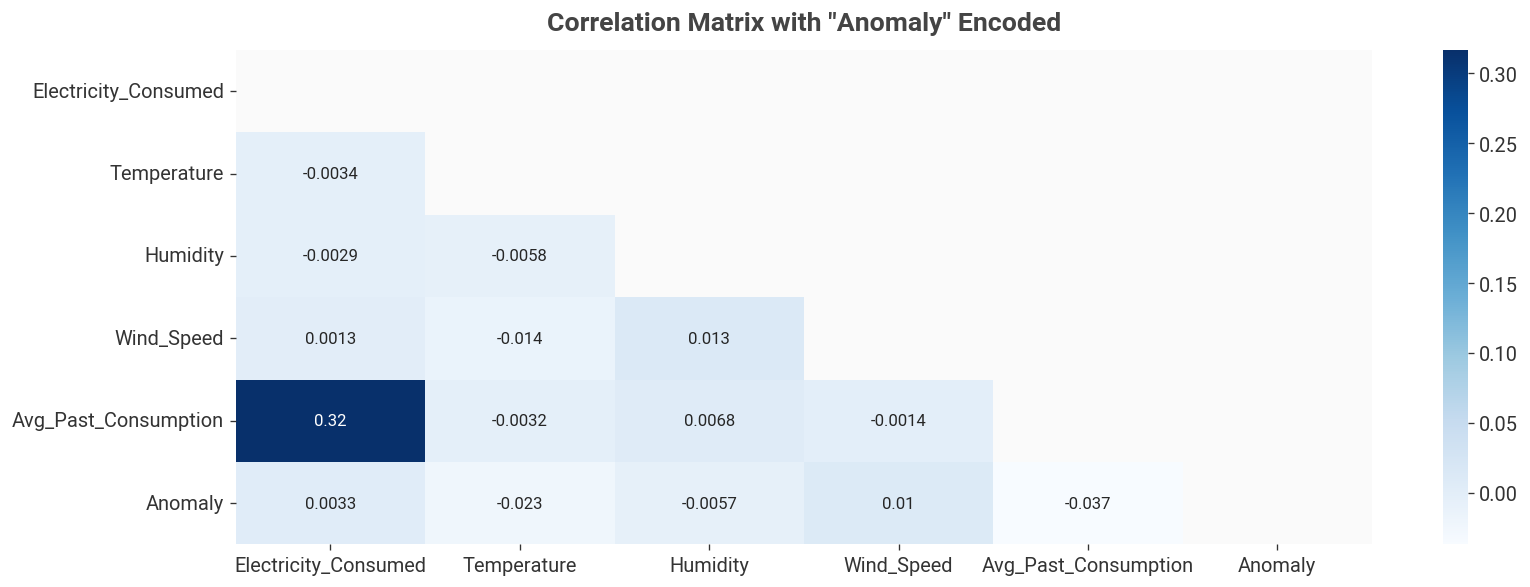

In [9]:
correlation_matrix = data_copy_1.drop(['Timestamp'], axis=1).corr()

plt.figure(figsize=(14, 5))
sns.heatmap(correlation_matrix, annot=True, mask=np.triu(np.ones_like(correlation_matrix)), cmap='Blues')
plt.title('Correlation Matrix with "Anomaly" Encoded');
plt.grid(alpha=0.0)

In [10]:
date_series = pd.to_datetime(data.Timestamp)
print(date_series.head(5))

0   2024-01-01 00:00:00
1   2024-01-01 00:30:00
2   2024-01-01 01:00:00
3   2024-01-01 01:30:00
4   2024-01-01 02:00:00
Name: Timestamp, dtype: datetime64[ns]


<hr style="background-color: white; height: 15px; border:none;">

# <center> Feature Engineering </center>

1. Extract a **Workday** feature from Timestamp feature
    * If it's a workday: 1
    * Else: 0

In [11]:
print(date_series.dt.weekday.value_counts())

workday = ( date_series.dt.weekday < 5 ).astype(int)

Timestamp
0    720
1    720
2    720
3    720
4    720
5    720
6    680
Name: count, dtype: int64


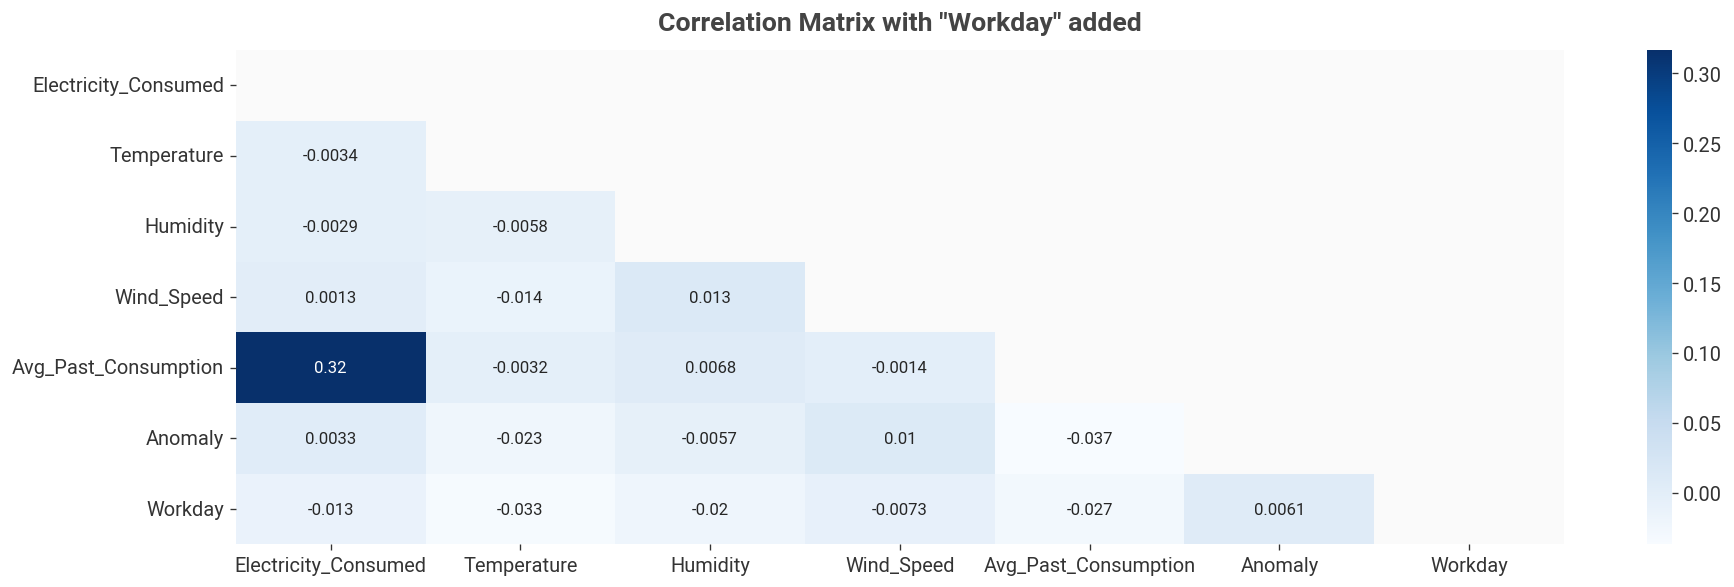

In [12]:
data_copy_1['Workday'] = workday

correlation_matrix = data_copy_1.drop(['Timestamp'], axis=1).corr()

plt.figure(figsize=(16, 5))
sns.heatmap( data_copy_1.drop('Timestamp', axis=1).corr(), annot=True, cmap='Blues', mask=np.triu(np.ones_like(correlation_matrix)))
plt.title('Correlation Matrix with "Workday" added')
plt.grid(alpha=0.0)

2. Extract a **day_part** feature from Timestamp feature:
    * If the hour between 0 and 6: **Late_Night**
    * If the hour between 6 and 12: **Morning**
    * If the hour between 12 and 18: **Afternoon**
    * If the hour between 18 and 24: **Early_Night**

In [13]:
# Convert to hour integers
hours = date_series.dt.hour

def convert(hour: int) -> str:
    if 0 <= hour < 6:
        return 'Late_Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'After_Noon'
    elif 18 <= hour < 24:
        return 'Early_Night'
    else:
        return 'NAN'
    
day_part = hours.apply(convert)
print(day_part.value_counts())

Timestamp
Late_Night     1256
Morning        1248
After_Noon     1248
Early_Night    1248
Name: count, dtype: int64


In [14]:
data_copy_1.sample(5)

,Timestamp,Electricity_Consumed,Temperature,Humidity,Wind_Speed,Avg_Past_Consumption,Anomaly,Workday
484,2024-01-11 02:00:00,0.248942,0.206415,0.579745,0.513966,0.530392,0,1
1148,2024-01-24 22:00:00,0.640751,0.328095,0.308356,0.393148,0.485387,0,1
1612,2024-02-03 14:00:00,0.522185,0.361838,0.566268,0.417314,0.387382,0,0
188,2024-01-04 22:00:00,0.233868,0.403200,0.530411,0.494231,0.547167,0,1
4351,2024-03-31 15:30:00,0.382916,0.590803,0.625664,0.433036,0.321066,0,0


In [15]:
day_part_ohe = pd.get_dummies(day_part, prefix='day_part', dtype=int)
day_part_ohe.sample(5, random_state=42)

,day_part_After_Noon,day_part_Early_Night,day_part_Late_Night,day_part_Morning
1501,0,0,0,1
2586,0,1,0,0
2653,0,0,0,1
1055,0,1,0,0
705,1,0,0,0


In [16]:
data_copy_2 = pd.concat( [data_copy_1, day_part_ohe], axis=1 )

In [17]:
data_copy_2.sample(5, random_state=42)

,Timestamp,Electricity_Consumed,Temperature,Humidity,Wind_Speed,Avg_Past_Consumption,Anomaly,Workday,day_part_After_Noon,day_part_Early_Night,day_part_Late_Night,day_part_Morning
1501,2024-02-01 06:30:00,0.283136,0.363988,0.557851,0.574558,0.850957,1,1,0,0,0,1
2586,2024-02-23 21:00:00,0.155125,0.386928,0.704744,0.365213,0.651421,0,1,0,1,0,0
2653,2024-02-25 06:30:00,0.546763,0.591185,0.552238,0.302088,0.426179,0,0,0,0,0,1
1055,2024-01-22 23:30:00,0.263063,0.727734,0.386598,0.398739,0.513191,0,1,0,1,0,0
705,2024-01-15 16:30:00,0.476002,0.246476,0.392256,0.629530,0.323443,0,1,1,0,0,0


<hr style="height: 15px; background-color: white; border: none;">


# <center> Data Preparation </center>

In [18]:
features = data_copy_2.drop(['Timestamp', 'Anomaly'], axis=1)
target = data_copy_2['Anomaly']

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25,
                                                    shuffle=True, stratify=target, random_state=42)

print(X_train.shape)
print(X_test.shape, '\n')
print(target.value_counts())

(3750, 10)
(1250, 10) 

Anomaly
0    4750
1     250
Name: count, dtype: int64


<hr style="height: 15px; background-color: white; border: none;">


# <center> Model Selection </center>

In [20]:
from sklearn.model_selection import StratifiedKFold

nfolds = 5
skfold = StratifiedKFold(n_splits=nfolds, random_state=42, shuffle=True)

In [21]:
import sys
sys.path.append('../../')

from my_utils.classification_eval_plots import ClassificationEvaluationPlots;
from my_utils.learnin_curve import plot_learning_curve

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

log_reg = LogisticRegression(class_weight='balanced')
svc = SVC(class_weight='balanced')
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type pr

[Logistic Regression] | Recall
Training Score:
[0.7384499  0.62658169 0.60181676 0.5996696  0.59138273 0.58123585
 0.57276199 0.56772346 0.5593948  0.5558234 ]
Validation Scores:
[0.35078236 0.42588905 0.46315789 0.44722617 0.39957326 0.43641536
 0.44665718 0.44125178 0.48406828 0.47354196]


[SVC] | Recall
Training Score:
[0.97894737 0.9358386  0.96388312 0.96849334 0.97822584 0.981678
 0.97695552 0.97678036 0.97783088 0.98273731]
Validation Scores:
[0.44182077 0.61692745 0.73926031 0.81394026 0.85106686 0.86187767
 0.86216216 0.89374111 0.91507824 0.92588905]


[Random Forest] | Recall
Training Score:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Validation Scores:
[0.30768137 0.41550498 0.52147937 0.56401138 0.59530583 0.63826458
 0.65391181 0.643101   0.65917496 0.67496444]


[Gradient Boosting] | Recall
Training Score:
[1.         1.         1.         1.         1.         1.
 1.         1.         0.99857143 0.9986755 ]
Validation Scores:
[0.60640114 0.75604552 0.74495021 0.75035562 0.7826458

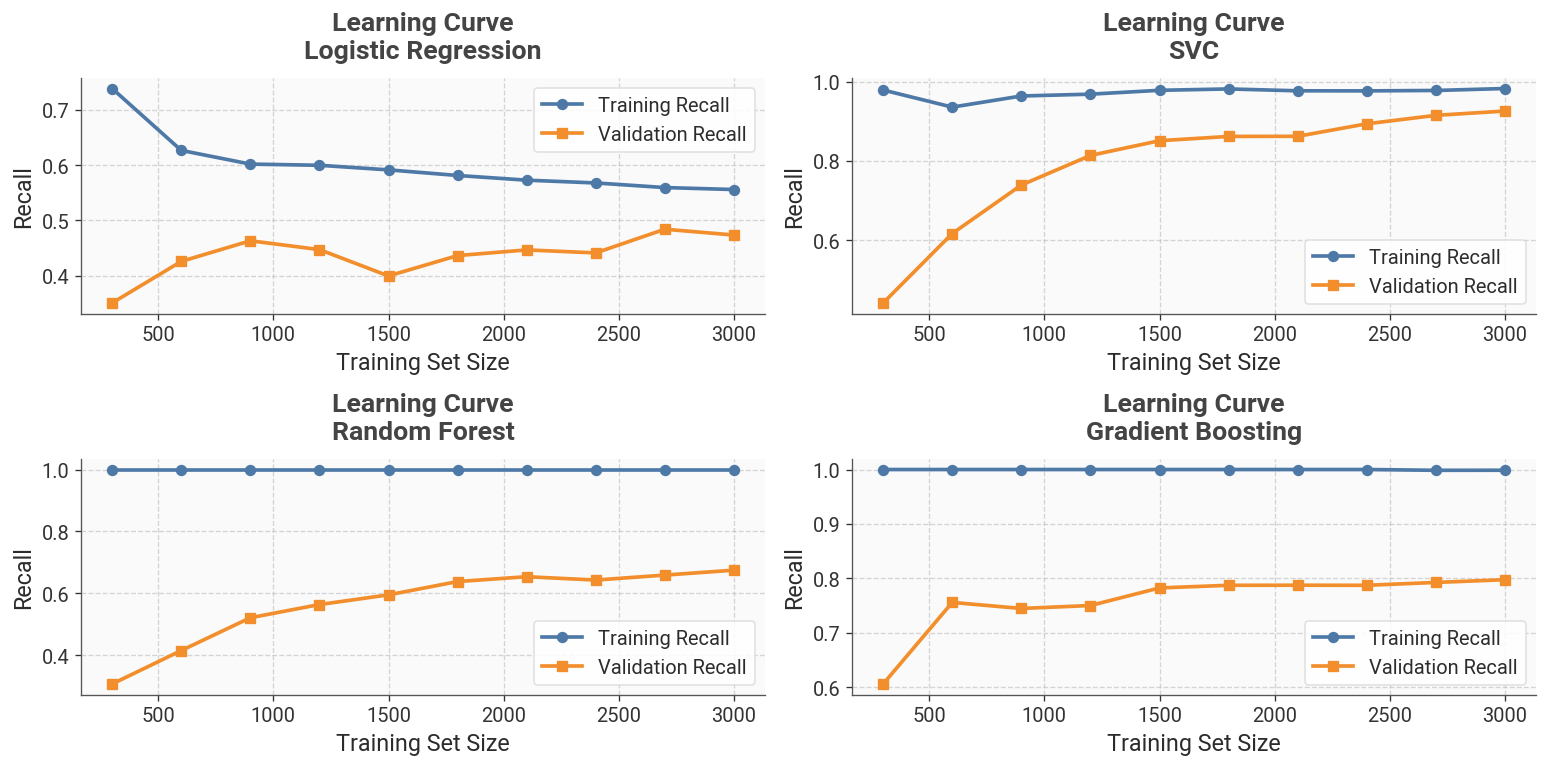

In [23]:
figure, axes = plt.subplots(2, 2, figsize=(13, 6.5))
axes = axes.flatten()

for ax, (model, model_name) in zip(axes, zip([log_reg, svc, rf, gb], ['Logistic Regression', 'SVC', 'Random Forest', 'Gradient Boosting'])):
    training_scores, validation_scores = plot_learning_curve(model=model, X=X_train, y=y_train,
                                                             cv=skfold, scoring='recall', ax=ax, label='Recall',
                                                             model_name=model_name)
    
    print(f'[{model_name}] | Recall')
    print(f'Training Score:\n{training_scores}')
    print(f'Validation Scores:\n{validation_scores}')

    print('\n')

* Support Vector Classifier is the winner here.
* The data set is 5,000 rows which is excellent for SVC.
* If the dataset grows much larger than this, that's when XGBoost or Light GBM comes into play

<hr style="height: 5px; background-color: white; border: none;">


# <center> Tuning SVC </center>

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [1, 5, 10, 50],
    'gamma': [0.1, 0.5, 1, 5],
}

grid = GridSearchCV(
    SVC(class_weight='balanced'),
    param_grid,
    scoring='recall',   # optimize for recall
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print(grid.best_params_)

{'C': 10, 'gamma': 0.5}


<hr style="height: 15px; background-color: white; border: none;">


# <center> Fitting SVC and Scoring </center>

In [25]:
svc_model = SVC(
    C=10,
    gamma=0.5,
    class_weight='balanced',
    probability=True,  # so that predict_proba method is available and will be used in plotting PR curve
).fit(X_train, y_train)
predictions_svc = svc_model.predict(X_test)

print(pd.Series(predictions_svc).value_counts())

0    1125
1     125
Name: count, dtype: int64


In [26]:
from sklearn.metrics import recall_score, precision_score, f1_score

recall = recall_score(y_test, predictions_svc)
precision = precision_score(y_test, predictions_svc)
f1 = f1_score(y_test, predictions_svc)

pd.DataFrame(index=['Recall', 'Precision', 'F1'], data={'value': [recall, precision, f1]})

,value
Recall,1.000000
Precision,0.496000
F1,0.663102


In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions_svc))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1188
           1       0.50      1.00      0.66        62

    accuracy                           0.95      1250
   macro avg       0.75      0.97      0.82      1250
weighted avg       0.98      0.95      0.96      1250



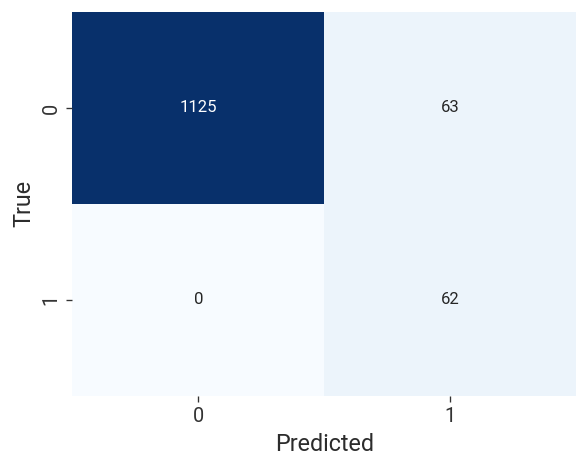

In [28]:
from sklearn.metrics import confusion_matrix

conf_mat_svc = confusion_matrix(y_test, predictions_svc)

plt.figure(figsize=(5, 4))

sns.heatmap(conf_mat_svc, cmap='Blues', annot=True, fmt='d', cbar=False)

plt.xlabel('Predicted')
plt.ylabel('True');
plt.grid(alpha=0.0)

In [29]:
plt.figure(figsize=(6, 4))
precisions, recalls = plot_precision_recall_curve(y_test, svc_model.predict_proba(X_test)[:, 1])

print('[Precisions]')
print(f'{precisions}')

print('-' * 50)

print('[Recalls]')
print(f'{recalls}')

NameError: name 'plot_precision_recall_curve' is not defined

<Figure size 720x480 with 0 Axes>

<hr style="height: 15px; background-color: white; border: none;">


# <center> SVC Stability </center>

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

figure, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (score_title, score_name) in zip(axes, zip( ['Recall', 'Precision', 'F1'], ['recall', 'precision', 'f1']) ):
    scores = cross_val_score(
        estimator=SVC(
            C=10,
            gamma=0.5,
            class_weight='balanced',
            probability=True,  # so that predict_proba method is available and will be used in plotting PR curve
        ),
    X=X_train, y=y_train, cv=cv, scoring=f'{score_name}')

    print(f'[{score_title}]')
    print(np.round(scores, 2))
    print('\n')
    
    mean_scores = np.mean(scores)

    sns.barplot(x=np.arange(1, 6), y=scores, palette='viridis', hue=np.arange(1, 6), legend=False, ax=ax)
    ax.axhline(y=mean_scores, color='black', linestyle='--', alpha=0.7, label=f'Mean {score_title}: {mean_scores:.2f}')
    ax.legend(loc='lower right')

figure.tight_layout()

<hr style="height: 15px; background-color: white; border: none;">

#  <center> Threshold Adjusting </center>

In [ ]:
decision_scores  = svc_model.decision_function(X_test)

print(decision_scores [decision_scores < 0.0].shape)  # Negative scores → predicted as class 0 (normal).
print(decision_scores [decision_scores > 0.0].shape)  # Positive scores → predicted as class 1 (anomaly).

threshold = 0.25
predictions_adjusted = (decision_scores > threshold).astype(int)

# Negative scores → predicted as class 0 (normal).
print(f'Negative class predictions after increasing threshold | {decision_scores [decision_scores < threshold].shape}')  

# Positive scores → predicted as class 0 (normal).
print(f'Positive class predictions after increasing threshold | {decision_scores [decision_scores > threshold].shape}')  

In [ ]:
recall_adjusted_threshold = recall_score(y_test, predictions_adjusted)
precision_adjusted_threshold = precision_score(y_test, predictions_adjusted)
f1_adjusted_threshold = f1_score(y_test, predictions_adjusted)

pd.DataFrame(index=['Recall', 'Precision', 'F1'],
             data={'value': [recall_adjusted_threshold, precision_adjusted_threshold, f1_adjusted_threshold]})

In [ ]:
conf_mat_svc_adjusted = confusion_matrix(y_test, predictions_adjusted)

sns.heatmap(conf_mat_svc_adjusted, cmap='Blues', annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True');
plt.grid(alpha=0.0)

### Adjusting the SVC Decision Threshold

Here, we manually adjusted the decision threshold of a trained SVC model to control the trade-off between **recall** and **precision** in anomaly detection.

**What changing the threshold does:**

- The SVC model outputs **decision scores** for each sample, which indicate how strongly the model believes a sample belongs to the positive class (anomaly).  
- By default, a score above 0.0 is classified as positive (anomaly), and below 0.0 as negative (normal).  
- Changing the threshold shifts this cutoff:
  - **Increasing the threshold** (e.g., from 0.0 → 0.25) means the model must be more confident before labeling a sample as an anomaly.
    - The number of positive class predictions decreases - lower recall - higher precision
  - **Decreasing the threshold** (e.g., from 0.0 → -0.2) means the model labels more samples as anomalies, even with lower confidence.
    - The number of positive class predictions increases - higher recall - lower precision
    
**Why it works:**

- Anomalies are rare, and false positives are costly. The raw model may be too aggressive in flagging anomalies at the default threshold.  
- By adjusting the threshold, we **filter out borderline predictions**:
  - High threshold → fewer false positives → higher precision.  
  - Low threshold → catch all anomalies → higher recall.

**How it improves performance:**

- The model itself is unchanged; it’s already trained and produces the same scores.  
- Threshold tuning improves the **usefulness of predictions**:
  - Reduces unnecessary alerts (false positives) without missing too many true anomalies.  
  - Optimizes F1 score or any other metric relevant to your application.
  
In short, threshold adjustment is a **post-training calibration** that makes the model’s predictions more actionable and aligned with operational priorities, especially in anomaly detection tasks.


<hr style="height: 15px; background-color: white; border: none;">



# <center> Gradient Boosting </center>

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier

# grad_boost = GradientBoostingClassifier(
#     n_estimators=300,       # more trees
#     learning_rate=0.05,     # smaller step size
#     max_depth=3,            # shallower trees → less memorization
#     min_samples_leaf=5,     # stops tiny splits
# ).fit(X_train, y_train)
# predictions_gb = grad_boost.predict(X_test)

# pd.Series( predictions_gb ).value_counts()

In [ ]:
# print(classification_report(y_test, predictions_gb))

# conf_mat_gb = confusion_matrix(y_test, predictions_gb)

# sns.heatmap(conf_mat_gb, cmap='Blues', annot=True, fmt='d', cbar=False)
# plt.xlabel('Predicted')
# plt.ylabel('True');
# plt.grid(alpha=0.0)
# print(conf_mat_gb)

In [ ]:
# from sklearn.model_selection import StratifiedKFold, cross_val_score

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# figure, axes = plt.subplots(1, 3, figsize=(14, 4))

# for ax, (score_title, score_name) in zip(axes, zip( ['F1', 'Precision', 'Recall'], ['f1', 'precision', 'recall']) ):
#     scores = cross_val_score(estimator=GradientBoostingClassifier(
#         n_estimators=300,       # more trees
#         learning_rate=0.05,     # smaller step size
#         max_depth=3,            # shallower trees → less memorization
#         min_samples_leaf=5,     # stops tiny splits
#     ), X=X_train, y=y_train, cv=cv, scoring=f'{score_name}')

#     print(f'[{score_title}]')
#     print(scores)
#     print('\n')

#     mean_scores = np.mean(scores)
#     sns.barplot(x=np.arange(1, 6), y=scores, palette='viridis', hue=np.arange(1, 6), legend=False, ax=ax)
#     ax.axhline(y=mean_scores, color='black', linestyle='--', alpha=0.7)

# figure.tight_layout()

In [ ]:
# feature_importance = pd.DataFrame( grad_boost.feature_importances_ ,index=features.columns, columns=['Feature_Importance'])

# plt.figure(figsize=(10, 5))
# sns.barplot(data=feature_importance, x='Feature_Importance', y=feature_importance.index, palette='viridis', hue=feature_importance.index)
# plt.ylabel('')